In [42]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import display, clear_output
import random

%matplotlib inline  

# retrieve data collected by fans online
#     describing rolls made by Travis in The Adventure Zone, 
# specifically 3 sub-arcs of "Balance": 
#     Petals to the Metal, The Crystal Kingdom, and The Eleventh Hour

#df = pd.read_csv(r"TravisRollsDataset.csv")
df = pd.read_csv(r"5krolls_plus_data.csv")
df.head()

,id,roll,adv,basis,type
0,0,20,none,initiative,NaN
1,1,15,none,melee,attack
2,2,2,none,melee,attack
3,3,16,advantage,perception,check
4,4,15,none,melee,attack


In [43]:
#subjectively categorize "important" rolls for Travis' character
# Magnus Burnsides is a barbarian warrior who succeeds by fighting
# We assume that fighting actions, or related actions are high 
# enough stakes to potentially cheat. Furthermore rolls at a 
# disadvantages are high enough stakes to potentially cheat. 
def assess_important(x):
    if x['adv']=="disadvantage" or x['basis'] in ["melee", "ranged", "dexterity", "strength"]:
        return 1
    else:
        return 0
df['important'] = df.apply(assess_important, axis=1)

In [44]:
# If Travis were cheating, the outcome would be higher
#than outerwise expected rolls. Therefore we must determine
#what exactly is a high roll, since a cheating roll would only be high. 
#Related to that, more cheating would mean fewer low rolls. 
#In D&D combat, you do not fight against the median d20 roll, 
#you fight against your other. 
lowest_high = 12

df['rolled'] = pd.Categorical(df.roll.apply(lambda x: \
            "high" if x>=lowest_high else "low"), categories=["low", "high"], ordered=True)
df.head()

,id,roll,adv,basis,type,important,rolled
0,0,20,none,initiative,NaN,0,high
1,1,15,none,melee,attack,1,high
2,2,2,none,melee,attack,1,low
3,3,16,advantage,perception,check,0,high
4,4,15,none,melee,attack,1,high


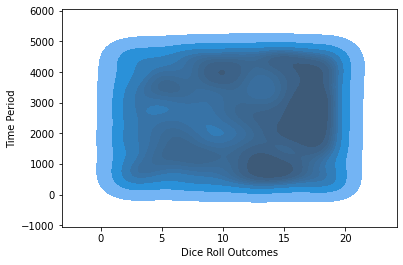

In [46]:
ax = sns.kdeplot(data=df, x="roll", y="id", fill=True)
ax.set(xlabel="Dice Roll Outcomes", ylabel = "Time Period");

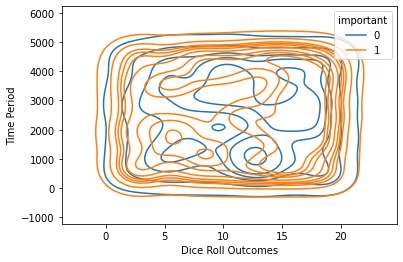

In [45]:
ax = sns.kdeplot(data=df, x="roll", y="id", hue="important")
ax.set(xlabel="Dice Roll Outcomes", ylabel = "Time Period");

In [50]:
df.roll.value_counts()

18    276
20    276
16    272
17    266
19    265
15    264
10    262
8     262
14    260
12    260
13    258
5     248
11    247
7     239
2     236
6     227
1     227
3     224
4     217
9     214
Name: roll, dtype: int64

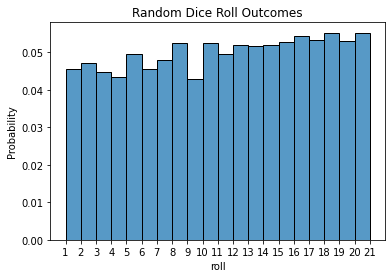

In [60]:
f, ax = plt.subplots()

rollhist = sns.histplot(data=df, x="roll", #hue='important', 
    stat="probability", ax=ax, 
    bins=np.histogram_bin_edges(df.roll, bins=list(range(1,22))))
rollhist.set_title("Random Dice Roll Outcomes")
rollhist.set(xticks=list(np.arange(1,22,1)));

## A Bayesian Analysis to Update the Likelihood of Dice Outcomes Given Advantage

$k$ = a given die side outcome $k \in \{1, 2, …, 19, 20\}$

$n_{k}$ = observed count of instances of a die side outcome (rolled a 4,7,20...)

prior $= P(k) = \frac{k}{\sum k}$ (uninformed)

likelihood $= P(k | n_{k}) = 1 + \frac{n_i}{\sum n_i}$

posterior $= P(n_{k} | k) = \frac{P(k | n_{k}) * P(n_{k})}{\sum_1^k P(k | n_{k}) * P(n_{k})}$

In [36]:
advantages = pd.DataFrame(df.adv.value_counts()) #count instances by advantage label
advantages['pct'] = advantages.adv / sum(advantages.adv) #find pct of all values
advantages = advantages.iloc[1:].copy() #REMOVE NA ROW

advantages['rolled'] = ["high", "low"]
advantages['lbound'] = [lowest_high, 1]
advantages['ubound'] = [20, lowest_high-1]

advantages['outcome_options'] = advantages.ubound - advantages.lbound + 1
# #prior probability of die outcomes, either high or low
advantages['prior'] = advantages.outcome_options/sum(advantages.outcome_options)

#likelihood of advantage/disadvantage states given data
#bayes multiplier, not a probability
advantages['likelihood'] = 1 + advantages.pct #change in representation given adv/disadv

#posterior probability of roll outcome given advantage/disadvantage observations
advantages['posterior'] = (advantages.likelihood * advantages.prior) \
    / sum(advantages.likelihood * advantages.prior)

advantages['per_outcome'] = advantages.posterior / advantages.outcome_options

advantages

,adv,pct,rolled,lbound,ubound,outcome_options,prior,likelihood,posterior,per_outcome
advantage,15,0.088235,high,12,20,9,0.45,1.088235,0.465214,0.051690
disadvantage,4,0.023529,low,1,11,11,0.55,1.023529,0.534786,0.048617


In [37]:
numberline_rodeo = df[["roll", "rolled", "id"]].\
    groupby(["roll", "rolled"]).count().reset_index().dropna().copy()
numberline_rodeo['pct'] = numberline_rodeo.id / sum(numberline_rodeo.id)
numberline_rodeo.head()

,roll,rolled,id,pct
0,1,low,4.0,0.023529
2,2,low,2.0,0.011765
4,3,low,3.0,0.017647
6,4,low,6.0,0.035294
8,5,low,2.0,0.011765


Based on our existing dataset, advantage and disadvantage are outside the control of the players, and we must assume the base rates of each as a given 

In [38]:
goat_rodeo = pd.merge(numberline_rodeo, 
                      advantages[["rolled", "per_outcome"]],
                      on="rolled", how="inner").copy()
goat_rodeo.columns = ["outcome", "range", "count", "observed_p", "expected_p"]

low_observed = goat_rodeo.query("range == 'low'").observed_p.to_numpy()
high_observed = goat_rodeo.query("range == 'high'").observed_p.to_numpy()
low_expected = goat_rodeo.query("range == 'low'").expected_p.to_numpy()
high_expected = goat_rodeo.query("range == 'high'").expected_p.to_numpy()

In [39]:
from scipy.stats import f_oneway

pd.DataFrame([list(f_oneway(low_observed, low_expected)), 
              list(f_oneway(high_observed, high_expected))],
            columns=["f_stat", "p_value"], index=["low", "high"])

,f_stat,p_value
low,139.101537,1.844711e-10
high,7.662278,1.371434e-02


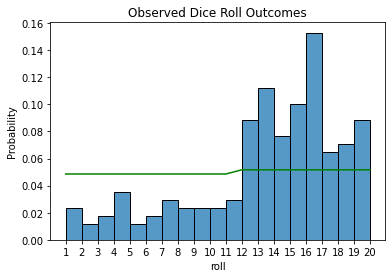

In [40]:
clear_output(wait = True)
ax.plot(goat_rodeo.outcome, goat_rodeo.expected_p, 'g-', label='Expected Density')
display(f);

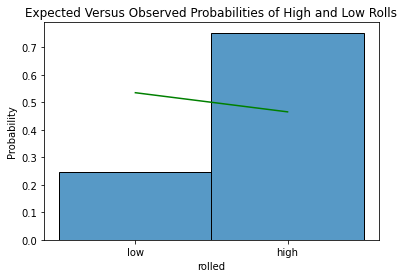

In [41]:
f1, ax1 = plt.subplots()

sns.histplot(data=df, x="rolled", stat="probability",ax=ax1)
ax1.set_title('Expected Versus Observed Probabilities of High and Low Rolls')
ax1.plot(advantages.rolled, \
         advantages.posterior, \
         'g-', label='Expected Density');

Means testing!! If the dice rolls are fair and random, there should be no difference in means.

$H_0: \mu_1 = \mu_2$  
$H_A: \mu_1 \neq \mu_2$

* repeated sequential context-driven needs for players to roll a die 
* goal to get a high number to accomplish things 
* the true outcome of the die is secret/hidden, and shared verbally by players
* rolls by players can be legitimate or fraudulent
* 

